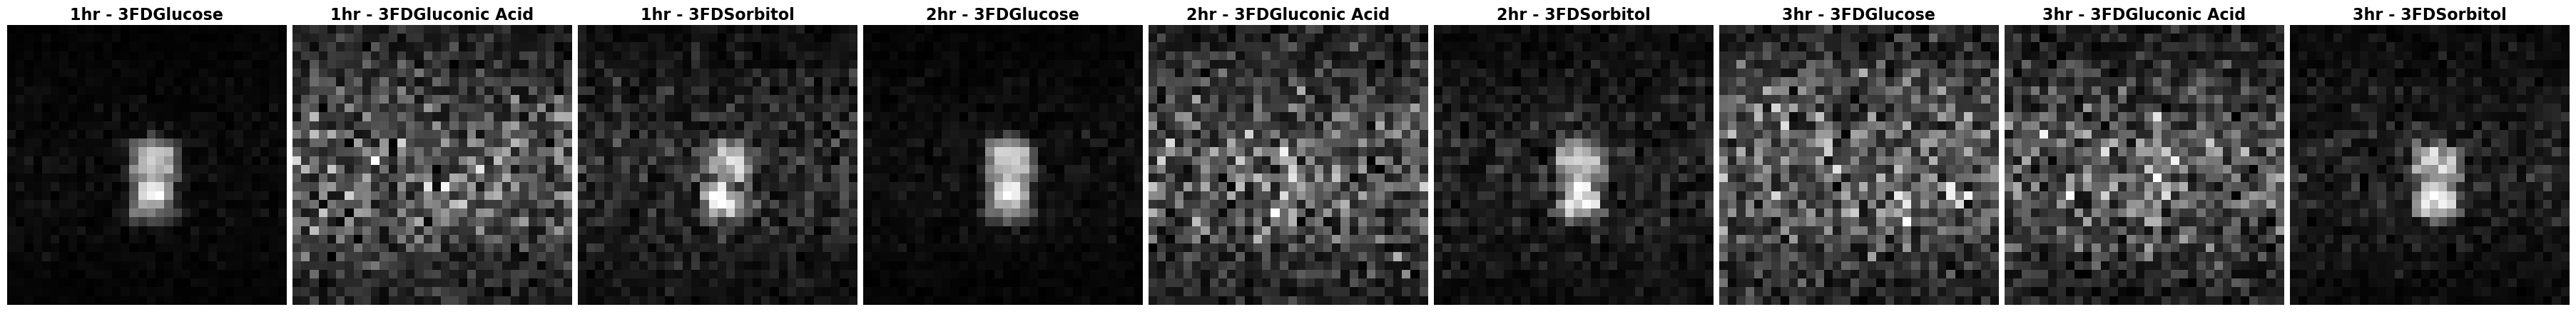

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

def load_mri_images(directory):
    """
    Loads MRI images from a specified directory and converts them to numpy arrays.
    Only loads images that start with '712' (for new 3FDG dataset) and are in TIFF format.
    
    Filename Structure:
    - 'p1'  → 3FDG Probe
    - 't1'  → 1hr after injection
    - 't2'  → 2hr after injection
    - 't3'  → 3hr after injection
    - 'm1'  → 3FDGlucose
    - 'm3'  → 3FDGluconic acid
    - 'm4'  → 3FDSorbitol
    
    The function will rename images based on this structure for improved readability.
    """
    images = {}
    for file_name in os.listdir(directory):
        if file_name.startswith("712") and file_name.endswith(".tif"):  # Adjusted for 712 dataset
            file_path = os.path.join(directory, file_name)
            img = Image.open(file_path)
            img_array = np.array(img)
            images[file_name] = img_array
    return images

def format_title(file_name):
    """Formats the filename into a more readable title."""
    parts = file_name.replace(".tif", "").split("_")
    if len(parts) < 4:
        return file_name  # Return as is if the format is unexpected
    
    time_map = {"t1": "1hr", "t2": "2hr", "t3": "3hr"}
    metabolite_map = {"m1": "3FDGlucose", "m3": "3FDGluconic Acid", "m4": "3FDSorbitol"}
    
    time = time_map.get(parts[2], parts[2])
    metabolite = metabolite_map.get(parts[3], parts[3])
    
    return f"{time} - {metabolite}"

def display_images(images):
    """
    Displays the MRI images in the Jupyter notebook with proper spacing.
    """
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 4, 5), constrained_layout=True)
    
    if num_images == 1:
        axes = [axes]  # Ensures iterability for a single image
    
    for ax, (file_name, img) in zip(axes, images.items()):
        ax.imshow(img, cmap="gray")
        ax.set_title(format_title(file_name), fontsize=16, fontweight='bold')
        ax.axis("off")
    
    plt.show()

# Define the main directory containing all data
parent_directory = r"C:\Users\libis\Desktop\weizmann\Python- Gabor"

# Handle hidden Unicode characters in the directory name
for folder in os.listdir(parent_directory):
    if "3FDG DATA+Analysis" in folder:
        main_directory = os.path.join(parent_directory, folder)
        break

# Load and display images from the new dataset
images = load_mri_images(main_directory)
display_images(images)


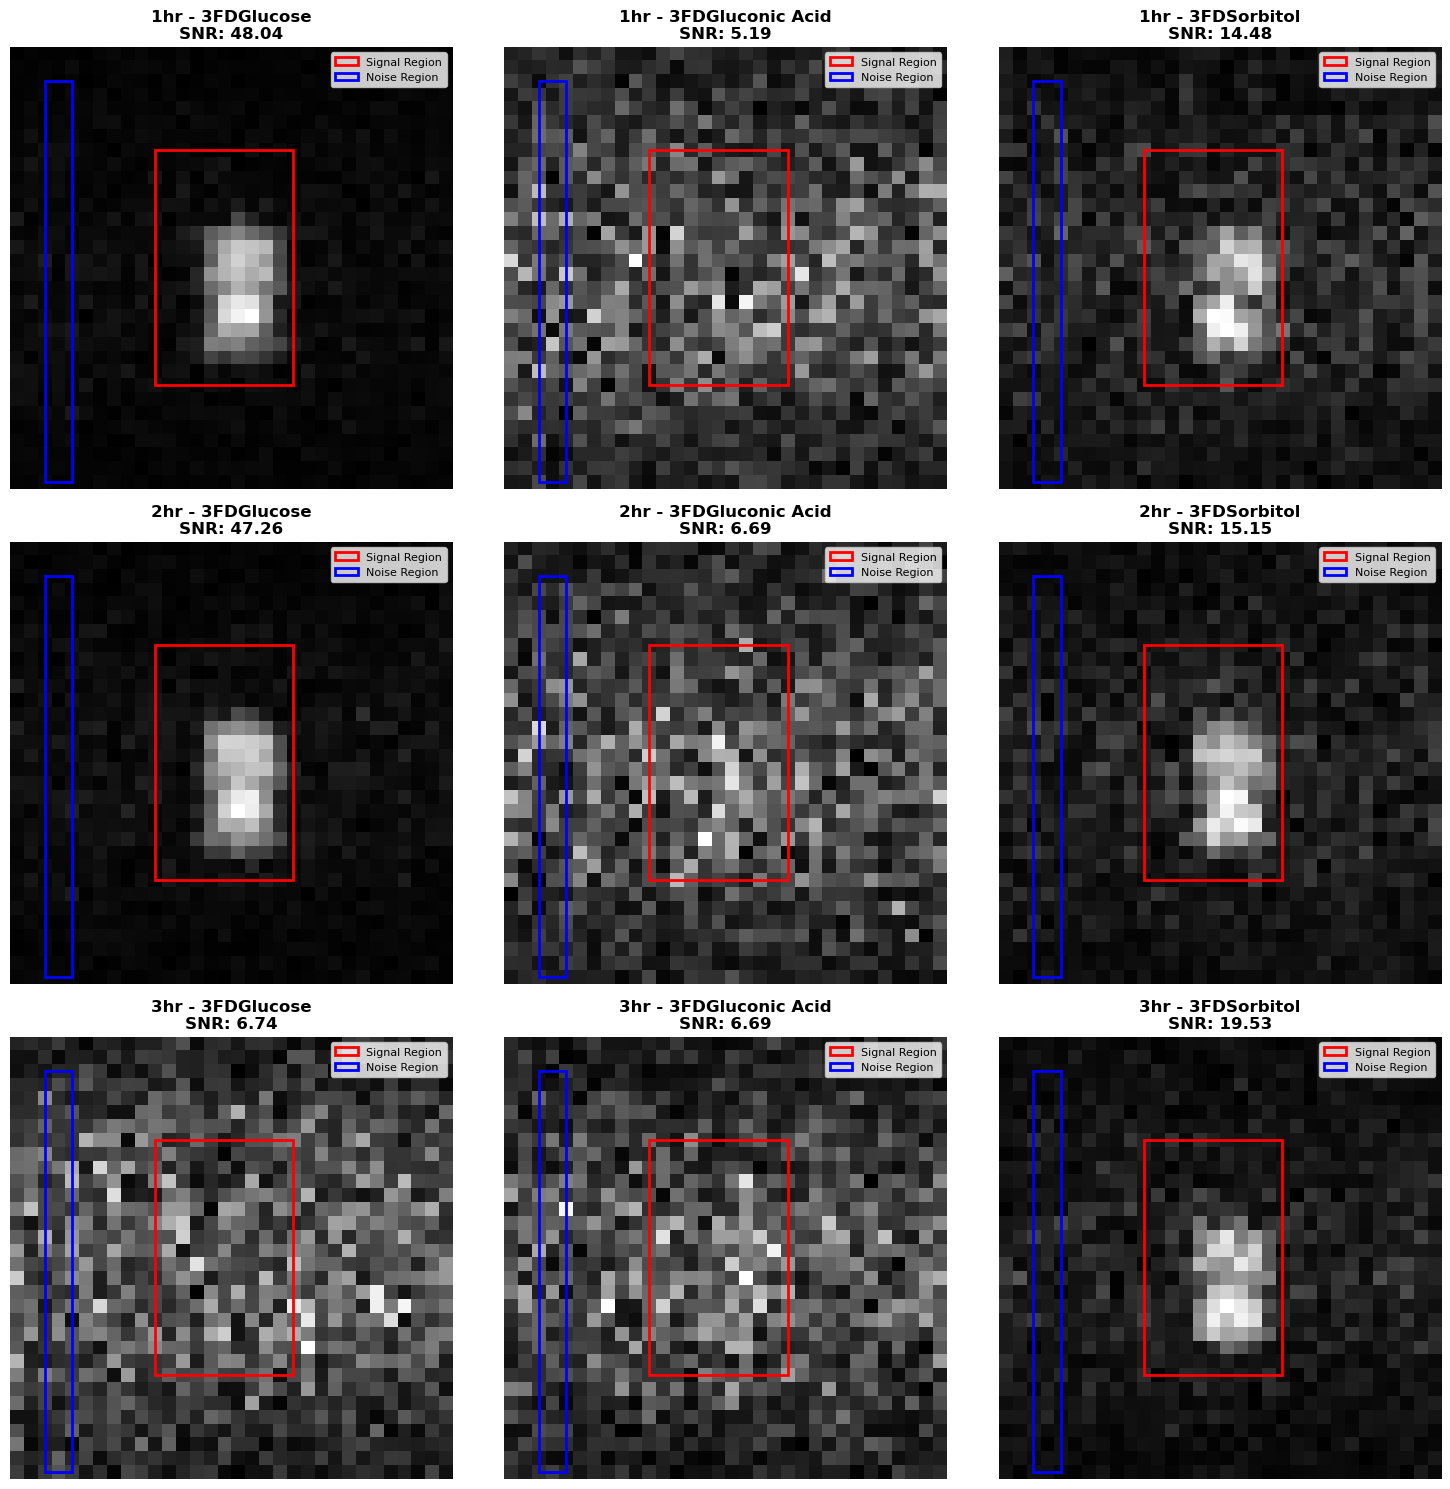

Combined SNR image saved at: C:\Users\libis\Desktop\weizmann\Python- Gabor\3FDG DATA+Analysis\SNR_3FDG\combined_snr_images.png


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import matplotlib.patches as patches

def compute_snr(image):
    """
    Computes the Signal-to-Noise Ratio (SNR) for the given image.
    The selected regions are carefully planned and consistent across experiments.
    
    - The signal region is chosen from a part of the image where the fluorinated sugar signal is expected to be the strongest.
    - The noise region is taken from an area that is not influenced by the signal, representing baseline noise.
    
    These regions are consistently positioned based on MRI experiment setup, ensuring relevant analysis across different scans.
    """
    
    signal_region = image[7:24, 10:20]  # Adjusted signal region
    noise_region = image[2:31, 2:4]  # Noise region remains unchanged
    
    noise = np.std(noise_region)
    max_signal = np.max(signal_region)
    snr = max_signal / noise if noise > 0 else 0
    
    return snr, max_signal, noise, noise_region  

def highlight_snr_regions_and_display_snr(images, output_dir):
    """
    Displays MRI images with SNR measurement regions, prints SNR values, 
    and saves the final combined image.
    """
    os.makedirs(output_dir, exist_ok=True)  # Create output directory if not exists
    
    num_images = len(images)
    cols = min(3, num_images)
    rows = (num_images // cols) + (num_images % cols > 0)
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    axes = np.array(axes).reshape(-1)
    
    for ax, (file_name, img) in zip(axes, images.items()):
        img_array = np.array(img)
        snr, max_signal, noise, _ = compute_snr(img_array)  # Ignore the 4th return value (noise_region)
        
        # Format title to include metabolite & time info
        formatted_title = format_title(file_name)
        
        ax.imshow(img_array, cmap="gray")
        ax.set_title(f"{formatted_title}\nSNR: {snr:.2f}", fontsize=12, fontweight='bold')
        ax.axis("off")
        
        # Draw signal and noise regions
        signal_rect = patches.Rectangle((10, 7), 10, 17, linewidth=2, edgecolor='r', facecolor='none', label="Signal Region")
        ax.add_patch(signal_rect)
        
        noise_rect = patches.Rectangle((2, 2), 2, 29, linewidth=2, edgecolor='b', facecolor='none', label="Noise Region")
        ax.add_patch(noise_rect)
        
        ax.legend(loc="upper right", fontsize=8)
    
    for ax in axes[len(images):]:
        ax.axis("off")
    
    plt.tight_layout()
    save_path = os.path.join(output_dir, "combined_snr_images.png")
    plt.savefig(save_path, dpi=300)
    plt.show()
    
    print(f"Combined SNR image saved at: {save_path}")

# Define title formatting function
def format_title(file_name):
    """Formats the filename into a readable title."""
    parts = file_name.replace(".tif", "").split("_")
    if len(parts) < 4:
        return file_name  # Return original name if format is unexpected
    
    time_map = {"t1": "1hr", "t2": "2hr", "t3": "3hr"}
    metabolite_map = {"m1": "3FDGlucose", "m3": "3FDGluconic Acid", "m4": "3FDSorbitol"}  # Updated for 3FDG data
    
    time = time_map.get(parts[2], parts[2])
    metabolite = metabolite_map.get(parts[3], parts[3])
    
    return f"{time} - {metabolite}"

# Define the main directory and output directory
parent_directory = r"C:\Users\libis\Desktop\weizmann\Python- Gabor"

# Handle hidden Unicode characters in the directory name
for folder in os.listdir(parent_directory):
    if "3FDG DATA+Analysis" in folder:
        main_directory = os.path.join(parent_directory, folder)
        break

output_directory = os.path.join(main_directory, "SNR_3FDG")  # Updated folder name for 3FDG

# Use previously loaded images and process them
highlight_snr_regions_and_display_snr(images, output_directory)


In [33]:
import pandas as pd
import os
import numpy as np

"""
This script saves SNR results to an Excel file with multiple sheets for better organization.
The script requires the 'xlsxwriter' module for writing Excel files.
If 'xlsxwriter' is not installed, it can be installed manually using:

    pip install xlsxwriter

Ensure that the package is installed before running this script.
"""

def save_snr_to_excel(images, output_dir):
    """
    Computes and saves SNR values of MRI images specifically for the 3FDG probe into an Excel file.
    
    This function extracts the Signal-to-Noise Ratio (SNR) from each image related to 3FDG,
    ensuring that only relevant files are processed.
    
    Parameters:
    - images: Dictionary containing image filenames as keys and image data as values.
    - output_dir: The directory where the Excel file will be saved.
    
    Output:
    - An Excel file storing the SNR values with separate sheets for each metabolite.
    """
    os.makedirs(output_dir, exist_ok=True)  # Ensure output directory exists

    # Updated metabolite names for 3FDG dataset
    metabolite_map = {
        "m1": "3FDGlucose",
        "m3": "3FDGluconic Acid",
        "m4": "3FDSorbitol"
    }

    time_map = {"t1": "1hr", "t2": "2hr", "t3": "3hr"}

    # Dictionary to store data for separate sheets
    metabolite_data = {met: [] for met in metabolite_map.values()}
    summary_data = []

    for file_path, img in images.items():
        if "p1" in file_path.lower():  # Ensuring only 3FDG files are processed
            snr, max_signal, noise, _ = compute_snr(np.array(img))  # Ignore noise_region
            
            # Extract metabolite and time information from filename
            parts = file_path.replace(".tif", "").split("_")
            if len(parts) < 4:
                continue  # Skip if format is unexpected
            
            time_label = time_map.get(parts[2], parts[2])
            metabolite_label = metabolite_map.get(parts[3], parts[3])
            
            # Append data to relevant metabolite sheet
            metabolite_data[metabolite_label].append([file_path, time_label, snr, max_signal, noise])
            
            # Append to summary data
            summary_data.append([file_path, metabolite_label, time_label, snr, max_signal, noise])

    # Create a Pandas Excel writer
    output_excel = os.path.join(output_dir, "SNR_Results_3FDG.xlsx")
    with pd.ExcelWriter(output_excel, engine="xlsxwriter") as writer:
        # Write summary sheet
        summary_df = pd.DataFrame(summary_data, columns=["Filename", "Metabolite", "Time", "SNR", "Max Signal", "Noise Std Dev"])
        summary_df.to_excel(writer, sheet_name="Summary", index=False)
        
        # Write separate sheets for each metabolite
        for met, data in metabolite_data.items():
            df = pd.DataFrame(data, columns=["Filename", "Time", "SNR", "Max Signal", "Noise Std Dev"])
            df.to_excel(writer, sheet_name=met, index=False)

    print(f"SNR results saved to: {output_excel}")

# Define output directory (same as previous SNR image folder)
main_directory = r"C:\Users\libis\Desktop\weizmann\Python- Gabor\3FDG DATA+Analysis"  # Updated for 3FDG
output_directory = os.path.join(main_directory, "SNR_3FDG")  # Updated for 3FDG

# Run function to save SNR results for 3FDG in Excel format
save_snr_to_excel(images, output_directory)


SNR results saved to: C:\Users\libis\Desktop\weizmann\Python- Gabor\3FDG DATA+Analysis\SNR_3FDG\SNR_Results_3FDG.xlsx


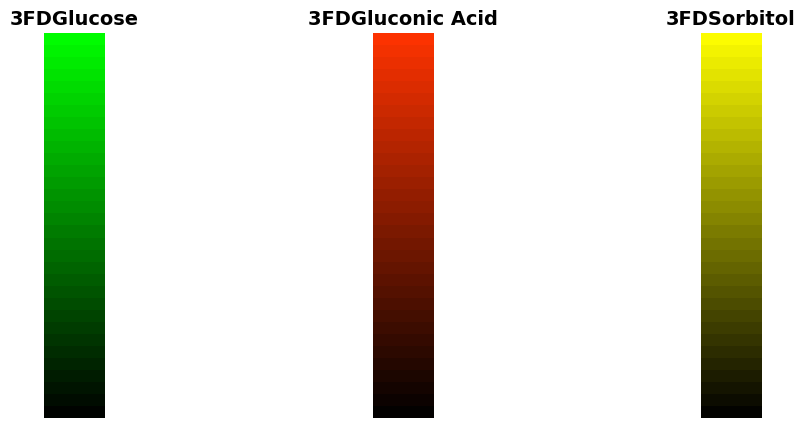

In [35]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def format_colormap_title(file_name):
    """Formats the filename into a readable title based on the metabolite type."""
    colormap_map = {
        "green": "3FDGlucose",
        "red": "3FDGluconic Acid",
        "yellow": "3FDSorbitol"
    }
    
    for key in colormap_map.keys():
        if key in file_name.lower():
            return colormap_map[key]
    
    return "Unknown Metabolite"

def load_colormap_images(directory):
    """
    Loads colormap images from the specified directory.
    Only loads TIFF images that contain 'cropped_32' in their filename.
    """
    colormap_dict = {}
    
    if not os.path.exists(directory):
        print(f"⚠ Warning: Directory '{directory}' does not exist.")
        return colormap_dict
    
    for file_name in os.listdir(directory):
        if "cropped_32" in file_name.lower() and file_name.endswith(".tif"):
            file_path = os.path.join(directory, file_name)
            img = Image.open(file_path)
            colormap_dict[file_name] = img

    if not colormap_dict:
        print("⚠ No colormap images found in the directory.")
    
    return colormap_dict

def display_colormap_images(colormap_dict):
    """
    Displays colormap images with proper titles.
    """
    num_images = len(colormap_dict)
    
    if num_images == 0:
        print("⚠ No colormap images to display.")
        return
    
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 4, 5))
    
    if num_images == 1:
        axes = [axes]  # Ensures iterability for a single image
    
    for ax, (file_name, img) in zip(axes, colormap_dict.items()):
        ax.imshow(img)
        ax.set_title(format_colormap_title(file_name), fontsize=14, fontweight='bold')
        ax.axis("off")
    
    plt.show()

# Define the parent directory
parent_directory = r"C:\Users\libis\Desktop\weizmann\Python- Gabor"

# Handle hidden Unicode characters in the directory name
for folder in os.listdir(parent_directory):
    if "3FDG DATA+Analysis" in folder:
        main_directory = os.path.join(parent_directory, folder)
        break

# Load and display colormap images
colormap_dict = load_colormap_images(main_directory)
display_colormap_images(colormap_dict)


Saved colored image: C:\Users\libis\Desktop\weizmann\Python- Gabor\3FDG DATA+Analysis\Colored_SNR_Analysis\Colored_712_p1_t1_m1.tif
3FDGlucose - 1hr after injection: SNR = 48.04, Max Signal = 32766, Noise Std Dev = 682.08
Saved colored image: C:\Users\libis\Desktop\weizmann\Python- Gabor\3FDG DATA+Analysis\Colored_SNR_Analysis\Colored_712_p1_t1_m3.tif
3FDGluconic Acid - 1hr after injection: SNR = 5.19, Max Signal = 4221, Noise Std Dev = 812.57
Saved colored image: C:\Users\libis\Desktop\weizmann\Python- Gabor\3FDG DATA+Analysis\Colored_SNR_Analysis\Colored_712_p1_t1_m4.tif
3FDSorbitol - 1hr after injection: SNR = 14.48, Max Signal = 8724, Noise Std Dev = 602.60
Saved colored image: C:\Users\libis\Desktop\weizmann\Python- Gabor\3FDG DATA+Analysis\Colored_SNR_Analysis\Colored_712_p1_t2_m1.tif
3FDGlucose - 2hr after injection: SNR = 47.26, Max Signal = 32766, Noise Std Dev = 693.31
Saved colored image: C:\Users\libis\Desktop\weizmann\Python- Gabor\3FDG DATA+Analysis\Colored_SNR_Analysis\C

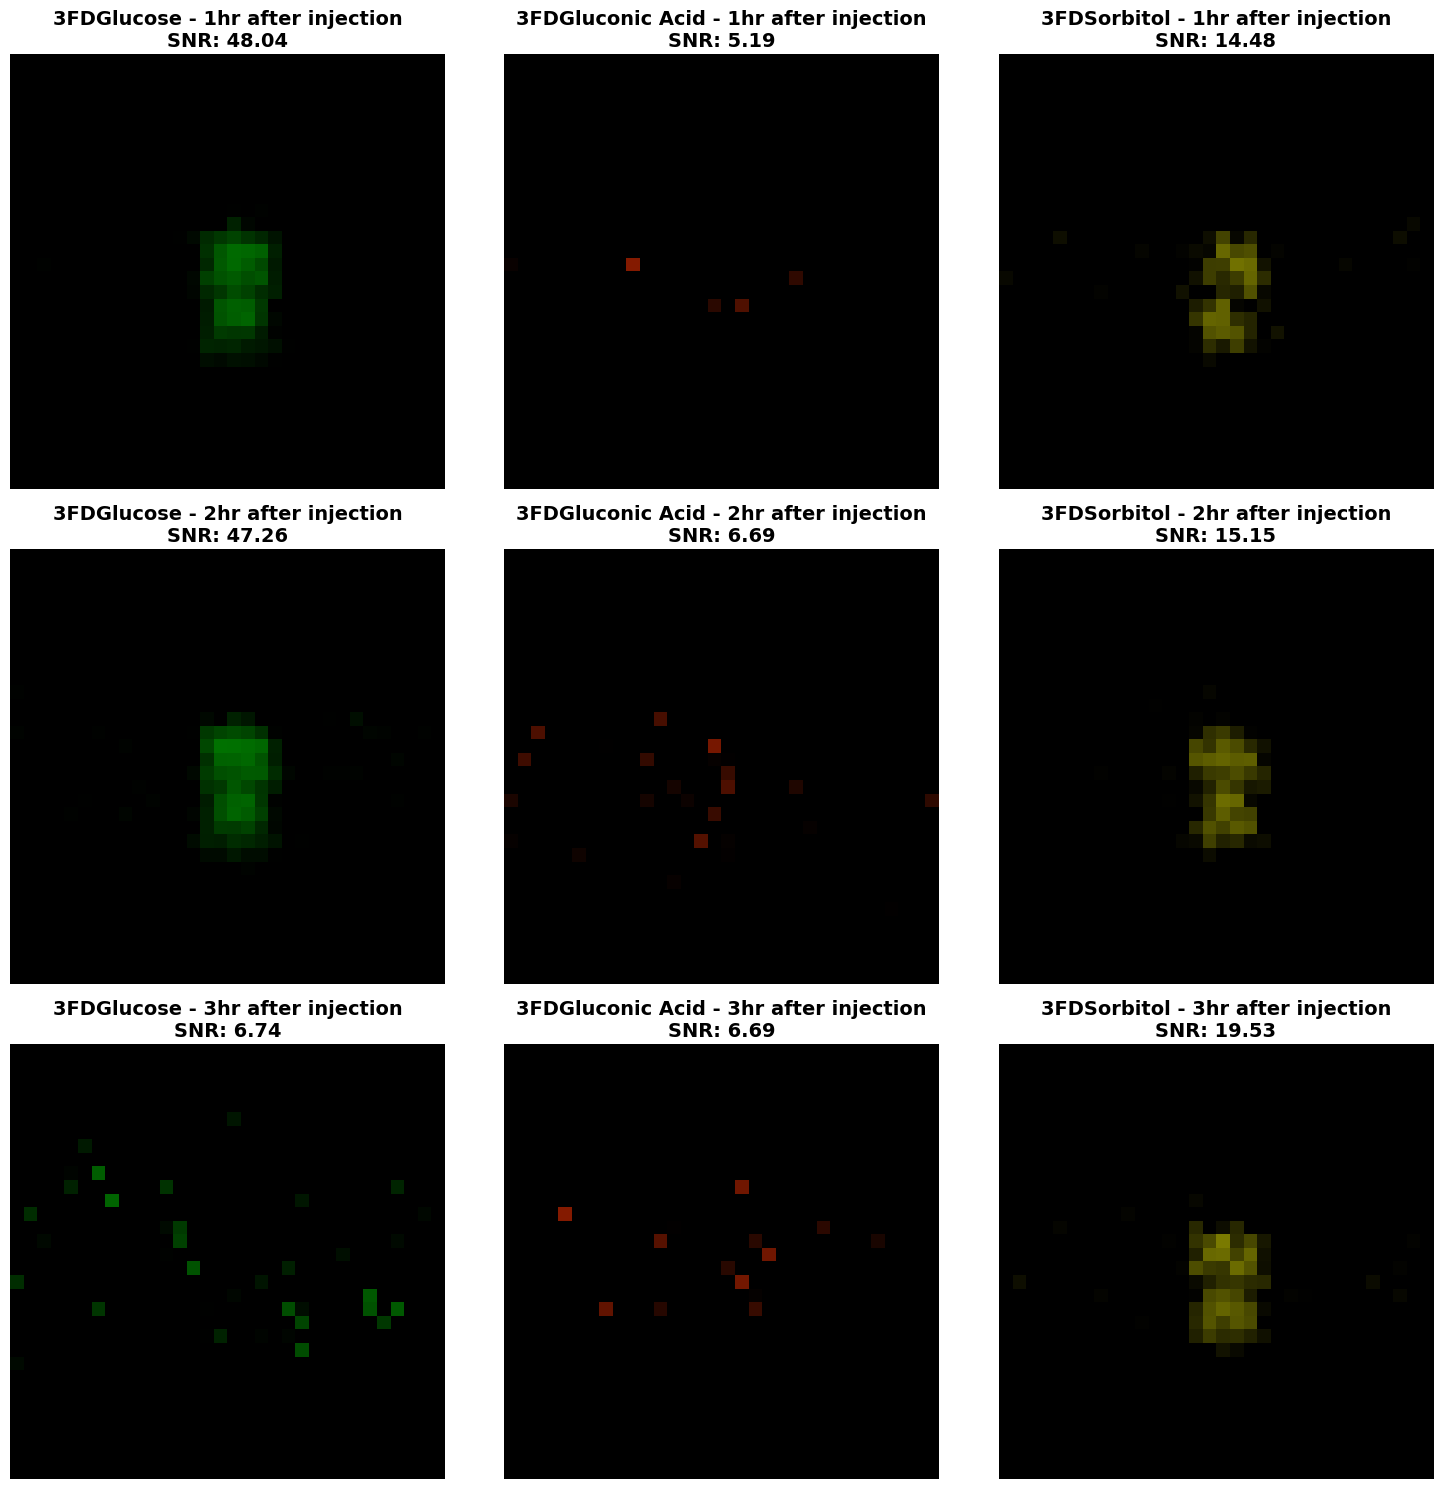

In [37]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

"""
This script applies external colormap images to MRI grayscale scans.
- It first computes the Signal-to-Noise Ratio (SNR) for each image.
- Background noise is filtered out to enhance visualization.
- External colormaps are applied to highlight specific metabolite signals.
- Each processed image is saved individually, and a combined figure is also generated.
"""

def compute_snr(image):
    """
    Computes the Signal-to-Noise Ratio (SNR) for the given image.
    """
    signal_region = image[7:24, 10:20]  
    noise_region = image[2:31, 2:4]  

    noise = np.std(noise_region)
    max_signal = np.max(signal_region)
    snr = max_signal / noise if noise > 0 else 0

    return snr, max_signal, noise, noise_region

def apply_external_colormap(image, colormap_image, noise_threshold):
    """
    Applies an external colormap image to the grayscale image while ensuring the background remains black.
    """
    image = np.array(image, dtype=np.float32)
    image[image < noise_threshold] = 0  

    norm_img = (image - noise_threshold) / (np.max(image) - noise_threshold + 1e-6)  
    norm_img[norm_img < 0] = 0  

    colormap_array = np.array(colormap_image.resize((image.shape[1], image.shape[0])))
    colored_img = (norm_img[..., None] * colormap_array).astype(np.uint8)
    return colored_img

def format_title(file_name):
    """Formats the filename into a readable title based on metabolite and time point."""
    time_map = {"t1": "1hr after injection", "t2": "2hr after injection", "t3": "3hr after injection"}
    metabolite_map = {"m1": "3FDGlucose", "m3": "3FDGluconic Acid", "m4": "3FDSorbitol"}  

    parts = file_name.replace(".tif", "").split("_")
    if len(parts) < 4:
        return file_name  

    time = time_map.get(parts[2], parts[2])
    metabolite = metabolite_map.get(parts[3], parts[3])

    return f"{metabolite} - {time}"

def display_and_save_colored_images(images, colormap_files, output_dir):
    """
    Displays MRI images with external colormaps applied and prints SNR values.
    Also saves each processed image and a combined image of all.
    """
    os.makedirs(output_dir, exist_ok=True)  # Create output directory if not exists
    
    colormap_mapping = {
        "m1": colormap_files.get("green"),  
        "m3": colormap_files.get("red"),  
        "m4": colormap_files.get("yellow")  
    }
    
    num_images = len(images)
    cols = min(3, num_images)  
    rows = (num_images // cols) + (num_images % cols > 0)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    axes = np.array(axes).reshape(-1)  

    all_colored_images = []

    for ax, (file_name, img) in zip(axes, images.items()):
        snr, max_signal, noise, noise_region = compute_snr(np.array(img))
        
        noise_threshold = np.mean(noise_region) + 3 * np.std(noise_region)  

        file_name = file_name.lower()
        colormap_image = None
        for key in colormap_mapping.keys():
            if f"_{key}.tif" in file_name:
                colormap_image = colormap_mapping[key]
                break

        if colormap_image:
            colored_img = apply_external_colormap(np.array(img), colormap_image, noise_threshold)
        else:
            colored_img = np.array(img)

        ax.imshow(colored_img)
        formatted_title = format_title(file_name)
        ax.set_title(f"{formatted_title}\nSNR: {snr:.2f}", fontsize=14, fontweight="bold")
        ax.axis("off")

        # Save each processed image
        save_path = os.path.join(output_dir, f"Colored_{file_name}")
        Image.fromarray(colored_img).save(save_path)
        print(f"Saved colored image: {save_path}")

        all_colored_images.append(colored_img)

        print(f"{formatted_title}: SNR = {snr:.2f}, Max Signal = {max_signal}, Noise Std Dev = {np.std(noise_region):.2f}")

    for ax in axes[len(images):]:
        ax.axis("off")

    plt.tight_layout()

    # Save combined figure with all colored images
    combined_save_path = os.path.join(output_dir, "All_Colored_SNR_Images.png")
    plt.savefig(combined_save_path, dpi=300)
    print(f"Combined colored image saved at: {combined_save_path}")

    plt.show()

# Define main directory where the data is stored
parent_directory = r"C:\Users\libis\Desktop\weizmann\Python- Gabor"

# Handle hidden Unicode characters in the directory name
for folder in os.listdir(parent_directory):
    if "3FDG DATA+Analysis" in folder:
        main_directory = os.path.join(parent_directory, folder)
        break

output_directory = os.path.join(main_directory, "Colored_SNR_Analysis")

# Load external colormap images
colormap_files = {
    "green": Image.open(os.path.join(main_directory, "green_cropped_32.tif")),
    "red": Image.open(os.path.join(main_directory, "red_cropped_32.tif")),
    "yellow": Image.open(os.path.join(main_directory, "yellow_cropped_32.tif"))
}

# Run function to apply external colormap, display results, and save output
display_and_save_colored_images(images, colormap_files, output_directory)


In [43]:
from PIL import Image, ImageEnhance
import numpy as np
import os
import matplotlib.pyplot as plt

def merge_mri_with_signal(mri_image_path, signal_images_folder, output_folder="merged_images", alpha=0.6, brightness_factor=1.5, signal_boost=1.2):
    """
    Merges MRI anatomical image with processed (colored) signal images, overlaying the signal map on the anatomical scan.

    Parameters:
    - mri_image_path: Path to the MRI grayscale image.
    - signal_images_folder: Path to the folder containing processed colored signal images.
    - output_folder: Directory to save merged images.
    - alpha: Transparency level for the signal overlay (0 = fully transparent, 1 = fully opaque).
    - brightness_factor: Factor to increase MRI image brightness.
    - signal_boost: Factor to increase signal intensity.

    Output:
    - Saves merged images where the colored signal is blended over the MRI scan.
    - Displays the merged images in a well-formatted plot with proper labels.
    """
    os.makedirs(output_folder, exist_ok=True)  # Ensure output directory exists

    # Load MRI image as grayscale and normalize
    mri_image = Image.open(mri_image_path)
    mri_array = np.array(mri_image, dtype=np.float32)
    mri_array = (mri_array - np.min(mri_array)) / (np.max(mri_array) - np.min(mri_array))
    mri_array = np.clip(mri_array * brightness_factor * 255, 0, 255)

    merged_images = []
    titles = []

    # Mapping for metabolite and time
    metabolite_map = {"m1": "3FDGlucose", "m3": "3FDGluconic Acid", "m4": "3FDSorbitol"}
    time_map = {"t1": "1h", "t2": "2h", "t3": "3h"}

    # **Filter only 712 images**
    signal_files = [f for f in sorted(os.listdir(signal_images_folder)) if f.startswith("712") and f.endswith(".tif")]

    if not signal_files:
        print("⚠ No valid images found for merging. Please check the filenames and directory.")
        return

    for file_name in signal_files:
        signal_image_path = os.path.join(signal_images_folder, file_name)
        signal_img = Image.open(signal_image_path).convert("RGB")  # Ensure signal image is in RGB

        # Extract metabolite and time information
        metabolite_key = next((key for key in metabolite_map if key in file_name), "Unknown")
        time_key = next((key for key in time_map if key in file_name), "Unknown")

        title = f"{metabolite_map.get(metabolite_key, 'Unknown')} - {time_map.get(time_key, 'Unknown')}"
        titles.append(title)

        # Resize signal image to match MRI
        signal_img_resized = signal_img.resize(mri_image.size, Image.BICUBIC)
        signal_array = np.array(signal_img_resized, dtype=np.float32)

        # Boost signal intensity
        signal_array = np.clip(signal_array * signal_boost, 0, 255)

        # Merge images with transparency
        merged_img = ((1 - alpha) * mri_array[..., None] + alpha * (signal_array / 255.0) * 255)
        merged_img = np.clip(merged_img, 0, 255).astype(np.uint8)

        # Save merged image
        save_path = os.path.join(output_folder, f"merged_{file_name}")
        Image.fromarray(merged_img).save(save_path)
        print(f"✅ Saved merged image: {save_path}")

        merged_images.append(merged_img)

    # Display merged images (Ensure only 9 images are shown)
    num_images = min(len(merged_images), 9)
    if num_images == 0:
        print("⚠ No images to display.")
        return

    cols = 3
    rows = (num_images + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))

    # **Make sure axes is always iterable**
    if rows * cols == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for ax, img, title in zip(axes[:num_images], merged_images[:num_images], titles[:num_images]):
        ax.imshow(img)
        ax.set_title(title, fontsize=12)
        ax.axis("off")

    # Hide any unused subplots
    for ax in axes[num_images:]:
        ax.axis("off")

    plt.tight_layout()

    # **Show the figure before saving to verify it's correct**
    plt.show()

    # **Save combined figure**
    combined_save_path = os.path.join(output_folder, "Merged_All_Images.png")
    fig.savefig(combined_save_path, dpi=300)
    print(f"✅ Combined merged image saved at: {combined_save_path}")

# **Set correct paths based on your computer**
parent_directory = r"C:\Users\libis\Desktop\weizmann\Python- Gabor"

# Locate correct folder with Unicode handling
for folder in os.listdir(parent_directory):
    if "3FDG DATA+Analysis" in folder:
        main_directory = os.path.join(parent_directory, folder)
        break

mri_image_path = os.path.join(main_directory, "rare_slice10_E25.tif")  # Updated RARE image
signal_images_folder = os.path.join(main_directory, "Colored_SNR_Analysis")
output_folder = os.path.join(main_directory, "Merged_Images")

# **Run function to merge MRI with processed colored signal images**
merge_mri_with_signal(mri_image_path, signal_images_folder, output_folder)


⚠ No valid images found for merging. Please check the filenames and directory.


✅ Saved merged image: C:\Users\libis\Desktop\weizmann\Python- Gabor\3FDG DATA+Analysis\Merged_Images\merged_Colored_712_p1_t1_m1.tif
✅ Saved merged image: C:\Users\libis\Desktop\weizmann\Python- Gabor\3FDG DATA+Analysis\Merged_Images\merged_Colored_712_p1_t1_m3.tif
✅ Saved merged image: C:\Users\libis\Desktop\weizmann\Python- Gabor\3FDG DATA+Analysis\Merged_Images\merged_Colored_712_p1_t1_m4.tif
✅ Saved merged image: C:\Users\libis\Desktop\weizmann\Python- Gabor\3FDG DATA+Analysis\Merged_Images\merged_Colored_712_p1_t2_m1.tif
✅ Saved merged image: C:\Users\libis\Desktop\weizmann\Python- Gabor\3FDG DATA+Analysis\Merged_Images\merged_Colored_712_p1_t2_m3.tif
✅ Saved merged image: C:\Users\libis\Desktop\weizmann\Python- Gabor\3FDG DATA+Analysis\Merged_Images\merged_Colored_712_p1_t2_m4.tif
✅ Saved merged image: C:\Users\libis\Desktop\weizmann\Python- Gabor\3FDG DATA+Analysis\Merged_Images\merged_Colored_712_p1_t3_m1.tif
✅ Saved merged image: C:\Users\libis\Desktop\weizmann\Python- Gabor\3

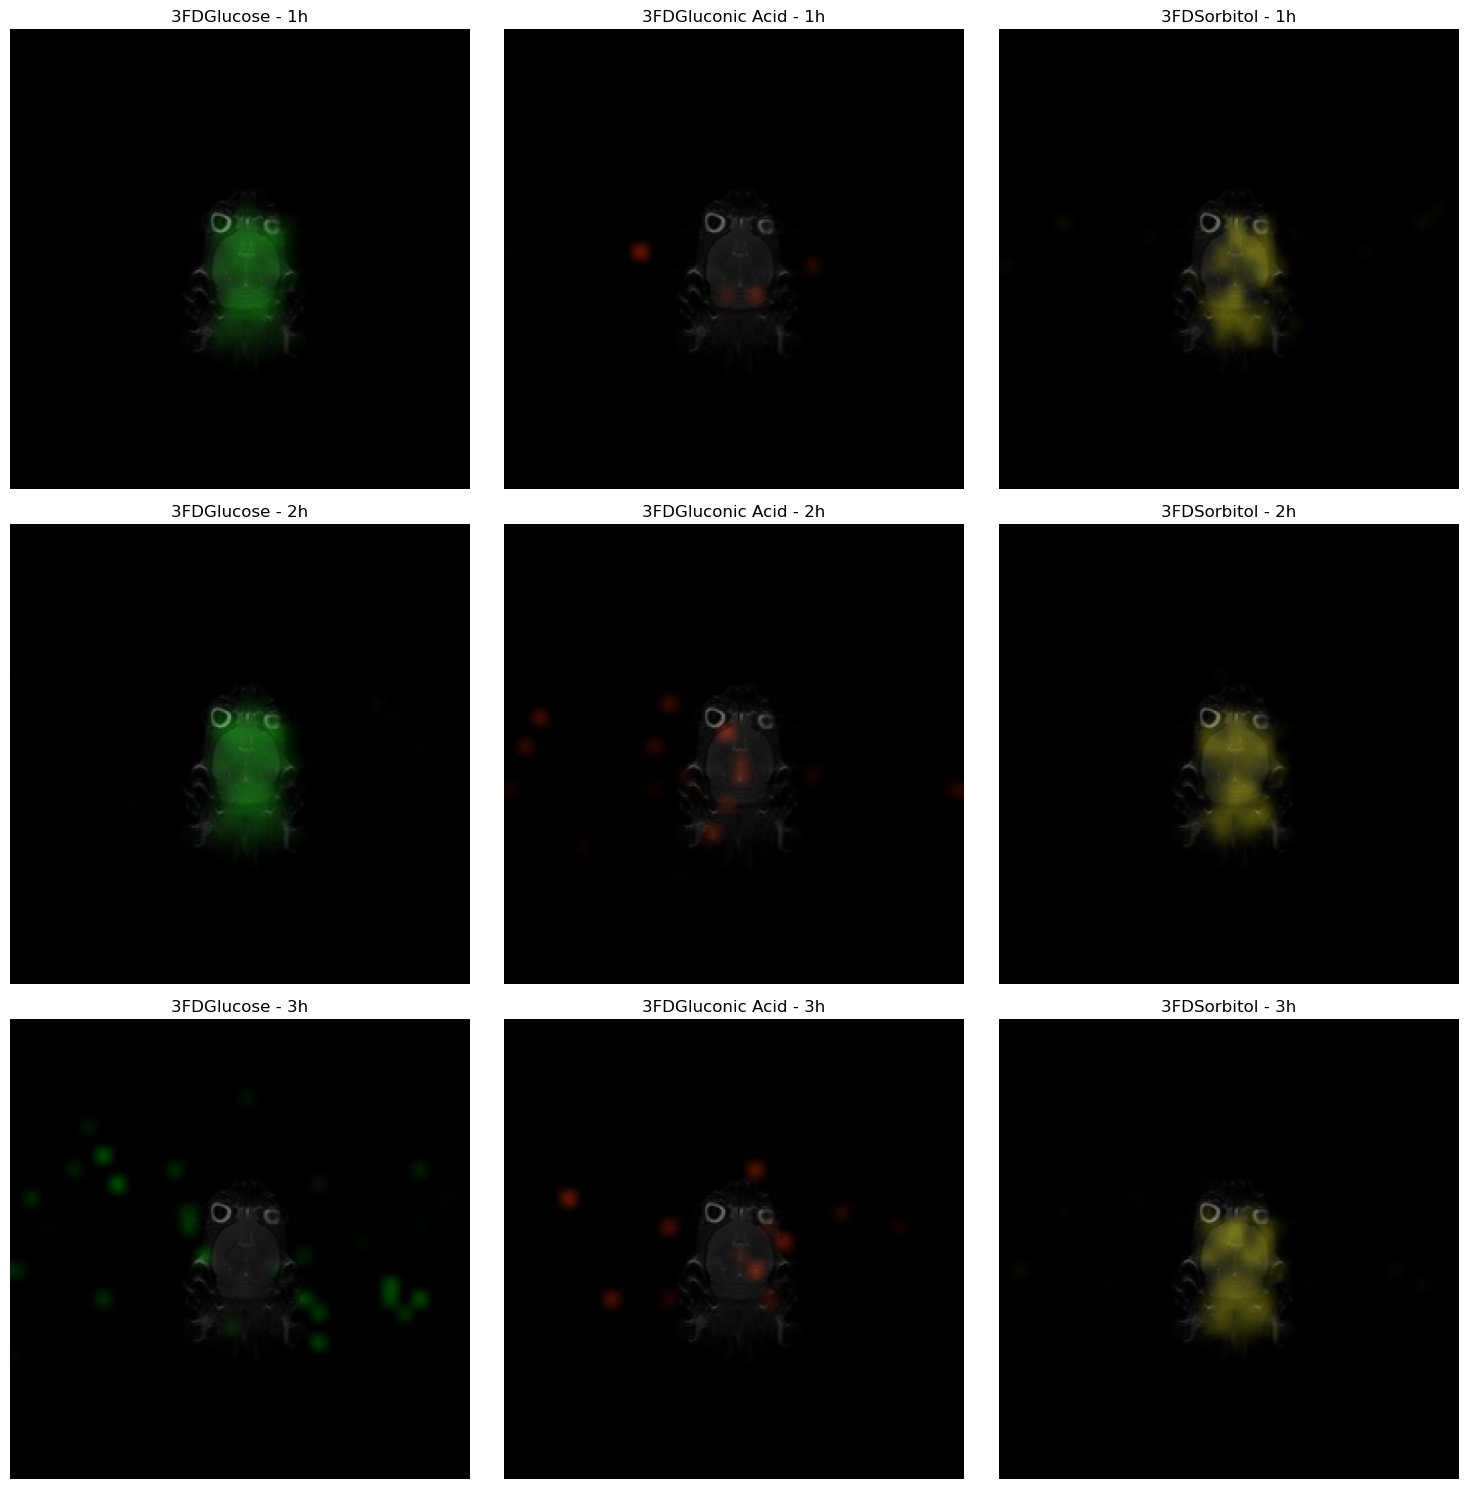

In [47]:
from PIL import Image, ImageEnhance
import numpy as np
import os
import matplotlib.pyplot as plt

def merge_mri_with_signal(mri_image_path, signal_images_folder, output_folder="merged_images", alpha=0.6, brightness_factor=1.5, signal_boost=1.2):
    """
    Merges MRI anatomical image with processed (colored) signal images, overlaying the signal map on the anatomical scan.

    Parameters:
    - mri_image_path: Path to the MRI grayscale image.
    - signal_images_folder: Path to the folder containing processed colored signal images.
    - output_folder: Directory to save merged images.
    - alpha: Transparency level for the signal overlay (0 = fully transparent, 1 = fully opaque).
    - brightness_factor: Factor to increase MRI image brightness.
    - signal_boost: Factor to increase signal intensity.

    Output:
    - Saves merged images where the colored signal is blended over the MRI scan.
    - Displays the merged images in a well-formatted plot with proper labels.
    """
    os.makedirs(output_folder, exist_ok=True)  # Ensure output directory exists

    # Load MRI image as grayscale and normalize
    mri_image = Image.open(mri_image_path)
    mri_array = np.array(mri_image, dtype=np.float32)
    mri_array = (mri_array - np.min(mri_array)) / (np.max(mri_array) - np.min(mri_array))
    mri_array = np.clip(mri_array * brightness_factor * 255, 0, 255)

    merged_images = []
    titles = []

    # Mapping for metabolite and time
    metabolite_map = {"m1": "3FDGlucose", "m3": "3FDGluconic Acid", "m4": "3FDSorbitol"}
    time_map = {"t1": "1h", "t2": "2h", "t3": "3h"}

    signal_files = [f for f in sorted(os.listdir(signal_images_folder)) if "Colored_712" in f and f.endswith(".tif")]

    if not signal_files:
        print("⚠ No valid images found for merging. Please check the filenames and directory.")
        return

    for file_name in signal_files:
        signal_image_path = os.path.join(signal_images_folder, file_name)
        signal_img = Image.open(signal_image_path).convert("RGB")  # Ensure signal image is in RGB

        # Extract metabolite and time information
        metabolite_key = next((key for key in metabolite_map if key in file_name), "Unknown")
        time_key = next((key for key in time_map if key in file_name), "Unknown")

        title = f"{metabolite_map.get(metabolite_key, 'Unknown')} - {time_map.get(time_key, 'Unknown')}"
        titles.append(title)

        # Resize signal image to match MRI
        signal_img_resized = signal_img.resize(mri_image.size, Image.BICUBIC)
        signal_array = np.array(signal_img_resized, dtype=np.float32)

        # Boost signal intensity
        signal_array = np.clip(signal_array * signal_boost, 0, 255)

        # Merge images with transparency
        merged_img = ((1 - alpha) * mri_array[..., None] + alpha * (signal_array / 255.0) * 255)
        merged_img = np.clip(merged_img, 0, 255).astype(np.uint8)

        # Save merged image
        save_path = os.path.join(output_folder, f"merged_{file_name}")
        Image.fromarray(merged_img).save(save_path)
        print(f"✅ Saved merged image: {save_path}")

        merged_images.append(merged_img)

    # Display merged images (Ensure only 9 images are shown)
    num_images = min(len(merged_images), 9)
    if num_images == 0:
        print("⚠ No images to display.")
        return

    cols = 3
    rows = (num_images + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axes = axes.flatten()

    for ax, img, title in zip(axes[:num_images], merged_images[:num_images], titles[:num_images]):
        ax.imshow(img)
        ax.set_title(title, fontsize=12)
        ax.axis("off")

    # Hide any unused subplots
    for ax in axes[num_images:]:
        fig.delaxes(ax)

    plt.tight_layout()

    # Save combined figure
    combined_save_path = os.path.join(output_folder, "Merged_All_Images.png")
    plt.savefig(combined_save_path, dpi=300)
    print(f"✅ Combined merged image saved at: {combined_save_path}")

    plt.show()

# **Set correct paths based on your computer**
parent_directory = r"C:\Users\libis\Desktop\weizmann\Python- Gabor"

# Locate correct folder with Unicode handling
for folder in os.listdir(parent_directory):
    if "3FDG DATA+Analysis" in folder:
        main_directory = os.path.join(parent_directory, folder)
        break

mri_image_path = os.path.join(main_directory, "rare_slice10_E25.tif")  # Updated RARE image
signal_images_folder = os.path.join(main_directory, "Colored_SNR_Analysis")
output_folder = os.path.join(main_directory, "Merged_Images")

# **Run function to merge MRI with processed colored signal images**
merge_mri_with_signal(mri_image_path, signal_images_folder, output_folder)


✅ Using Excel file: C:\Users\libis\Desktop\weizmann\Python- Gabor\3FDG DATA+Analysis\SNR_3FDG\SNR_Results_3FDG.xlsx
✅ Successfully loaded data from: C:\Users\libis\Desktop\weizmann\Python- Gabor\3FDG DATA+Analysis\SNR_3FDG\SNR_Results_3FDG.xlsx
✅ Plot saved at: C:\Users\libis\Desktop\weizmann\Python- Gabor\3FDG DATA+Analysis\SNR_Plots\SNR_Plot_3FDG.png


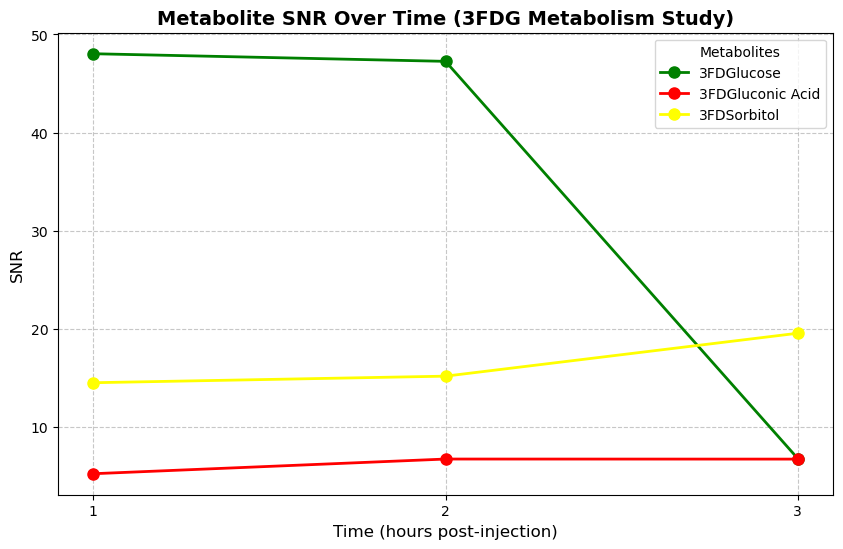

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def plot_snr_time_series(excel_file, output_folder):
    """
    Plots the time-series SNR changes for different metabolites of 3FDG.

    The function extracts SNR values from an Excel file and plots them
    for 3FDGlucose (M1), 3FDGluconic Acid (M3), and 3FDSorbitol (M4) over time.

    Timepoints are converted to actual hours post-injection:
    - T1 corresponds to 1 hour post-injection
    - T2 corresponds to 2 hours post-injection
    - T3 corresponds to 3 hours post-injection

    The resulting plot is saved as an image file in the specified output folder.
    """

    os.makedirs(output_folder, exist_ok=True)  # Ensure output folder exists

    # Load the Excel file
    try:
        df = pd.read_excel(excel_file, sheet_name="Summary")  # Load the summary sheet
        print(f"✅ Successfully loaded data from: {excel_file}")
    except Exception as e:
        print(f"❌ Error loading the Excel file: {e}")
        return

    # Extract timepoints and metabolites from filenames
    df["Timepoint"] = df["Filename"].str.extract(r"t(\d+)").astype(float)
    df["Metabolite"] = df["Filename"].str.extract(r"m(\d+)")

    # Map metabolite names for 3FDG
    metabolite_names = {
        "1": "3FDGlucose",
        "3": "3FDGluconic Acid",
        "4": "3FDSorbitol"
    }
    df["Metabolite"] = df["Metabolite"].map(metabolite_names)

    # Convert timepoints to actual hours post-injection
    time_mapping = {1: 1, 2: 2, 3: 3}  # T1 → 1h, T2 → 2h, T3 → 3h
    df["Time (hours post-injection)"] = df["Timepoint"].map(time_mapping)

    # Define colors for the metabolites
    color_mapping = {
        "3FDGlucose": "green",
        "3FDGluconic Acid": "red",
        "3FDSorbitol": "yellow"
    }

    # Plot settings
    plt.figure(figsize=(10, 6))

    for metabolite, color in color_mapping.items():
        subset = df[df["Metabolite"] == metabolite]
        plt.plot(
            subset["Time (hours post-injection)"],
            subset["SNR"],
            marker="o",
            markersize=8,
            linewidth=2,
            color=color,
            label=metabolite
        )

    # Style adjustments
    plt.xlabel("Time (hours post-injection)", fontsize=12)
    plt.ylabel("SNR", fontsize=12)
    plt.title("Metabolite SNR Over Time (3FDG Metabolism Study)", fontsize=14, fontweight="bold")
    plt.legend(fontsize=10, title="Metabolites")
    plt.xticks([1, 2, 3])
    plt.grid(True, linestyle="--", alpha=0.7)

    # Save plot
    output_path = os.path.join(output_folder, "SNR_Plot_3FDG.png")
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    print(f"✅ Plot saved at: {output_path}")

    # Show plot
    plt.show()


# **Set correct paths based on your computer**
parent_directory = r"C:\Users\libis\Desktop\weizmann\Python- Gabor"

# Locate correct folder with Unicode handling
for folder in os.listdir(parent_directory):
    if "3FDG DATA+Analysis" in folder:
        main_directory = os.path.join(parent_directory, folder)
        break

snr_directory = os.path.join(main_directory, "SNR_3FDG")  # Updated for 3FDG

# Find the Excel file
excel_files = [f for f in os.listdir(snr_directory) if f.endswith(".xlsx")]

if not excel_files:
    print("⚠ No Excel files found in the directory!")
else:
    excel_file = os.path.join(snr_directory, excel_files[0])  # Use the first Excel file found
    print(f"✅ Using Excel file: {excel_file}")

    # **Run function to generate and save the plot**
    output_folder = os.path.join(main_directory, "SNR_Plots")
    plot_snr_time_series(excel_file, output_folder)
